<a href="https://colab.research.google.com/github/aaperei/data-science/blob/main/neural_networks_unifesp_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecto Final - 2021/2S Redes Neurais - UNIFESP
Alison Augusto M Perera
---


O presente trabalho tem o objetivo de comparar diversos modelos de redes neurais do tipo `CNN` - *Convolutional Neural Networks* - na tarefa de classificação de imagens. Utilizou-se da técnica de *transfer learning* a fim de se reutilizar modelos pré-treinados, fazendo apenas pequenos ajustes na camada de saída do modelo para a adaptação para o conjunto de dados em questão.

# Processo utilizado
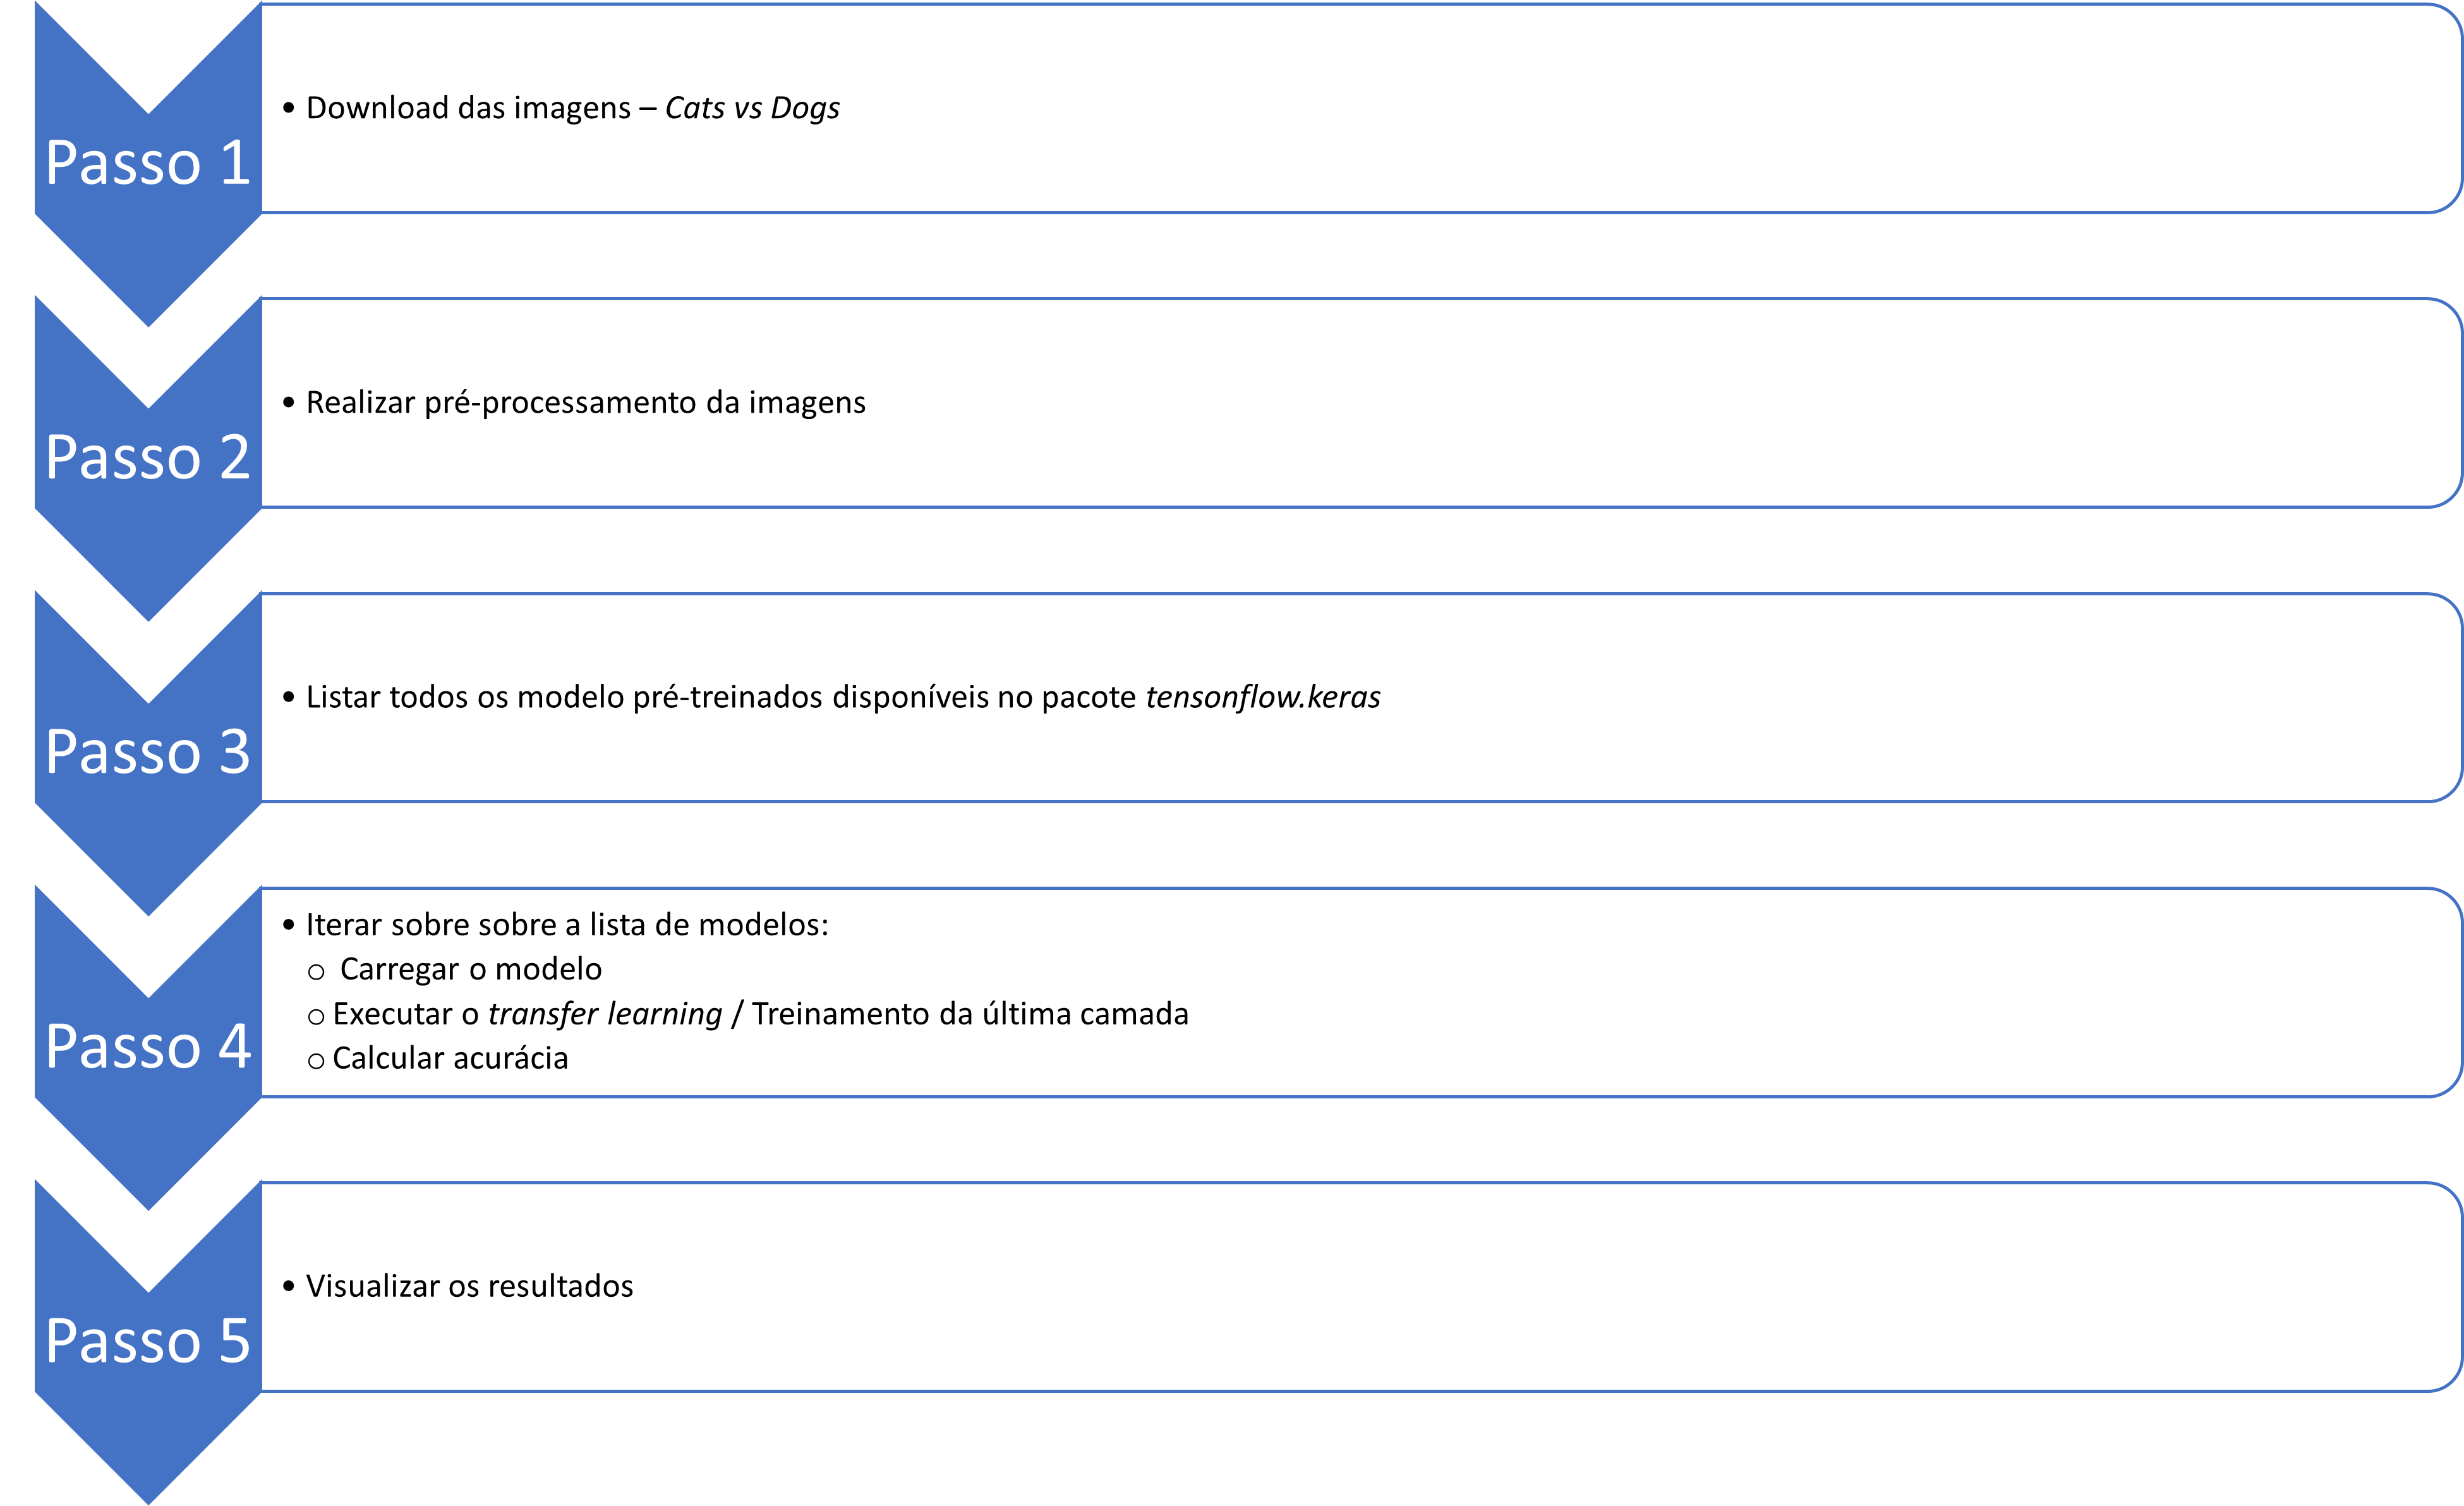



In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

In [2]:
# Download the training and validation data
(train, validation), metadata = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:]'], 
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZWVF6A/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Num train images: 16283         
Num validation images: 6979         
Num classes: 2         
Num iterations per epoch: 508


In [3]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

In [4]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1>,
 'EfficientNetB2': <function keras.applications.efficientnet.EfficientNetB2>,
 'EfficientNetB3': <function keras.applications.efficientnet.EfficientNetB3>,
 'EfficientNetB4': <function keras.applications.efficientnet.EfficientNetB4>,
 'EfficientNetB5': <function keras.applications.efficientnet.EfficientNetB5>,
 'EfficientNetB6': <function keras.applications.efficientnet.EfficientNetB6>,
 'EfficientNetB7': <function keras.applications.efficientnet.EfficientNetB7>,
 'InceptionResNetV2': <function keras.applications.inception_resnet_v2.InceptionResNetV2>,
 'InceptionV3': <function keras.applications.inception_v3.InceptionV3>,
 'MobileN

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

  0%|          | 0/28 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 186s 333ms/step - loss: 0.0771 - accuracy: 0.9691 - val_loss: 0.0398 - val_accuracy: 0.9838
Epoch 2/3
508/508 [==============================] - 167s 326ms/step - loss: 0.0369 - accuracy: 0.9858 - val_loss: 0.0395 - val_accuracy: 0.9844
Epoch 3/3
508/508 [==============================] - 166s 326ms/step - loss: 0.0333 - accuracy: 0.9879 - val_loss: 0.0348 - val_accuracy: 0.9867


  4%|▎         | 1/28 [09:34<4:18:22, 574.16s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 218s 406ms/step - loss: 0.0595 - accuracy: 0.9798 - val_loss: 0.0303 - val_accuracy: 0.9894
Epoch 2/3
508/508 [==============================] - 202s 397ms/step - loss: 0.0301 - accuracy: 0.9900 - val_loss: 0.0291 - val_accuracy: 0.9903
Epoch 3/3
508/508 [==============================] - 202s 397ms/step - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.0295 - val_accuracy: 0.9903


  7%|▋         | 2/28 [20:02<4:22:33, 605.89s/it]

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 269s 503ms/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 0.0271 - val_accuracy: 0.9900
Epoch 2/3
508/508 [==============================] - 252s 495ms/step - loss: 0.0303 - accuracy: 0.9890 - val_loss: 0.0262 - val_accuracy: 0.9908
Epoch 3/3
508/508 [==============================] - 251s 495ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 0.0266 - val_accuracy: 0.9904


 11%|█         | 3/28 [33:44<4:53:36, 704.68s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 98s 177ms/step - loss: 0.6976 - accuracy: 0.5018 - val_loss: 0.6947 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 90s 175ms/step - loss: 0.6973 - accuracy: 0.5018 - val_loss: 0.6976 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 88s 173ms/step - loss: 0.6972 - accuracy: 0.5013 - val_loss: 0.6929 - val_accuracy: 0.5038


 14%|█▍        | 4/28 [39:16<3:43:02, 557.60s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 135s 246ms/step - loss: 0.6991 - accuracy: 0.5030 - val_loss: 0.6987 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 122s 241ms/step - loss: 0.6994 - accuracy: 0.5000 - val_loss: 0.6949 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 122s 241ms/step - loss: 0.6993 - accuracy: 0.5024 - val_loss: 0.6928 - val_accuracy: 0.5038


 18%|█▊        | 5/28 [45:52<3:11:26, 499.43s/it]

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 143s 261ms/step - loss: 0.7017 - accuracy: 0.5050 - val_loss: 0.7044 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 131s 257ms/step - loss: 0.7018 - accuracy: 0.4984 - val_loss: 0.7074 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 130s 257ms/step - loss: 0.7015 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4963


 21%|██▏       | 6/28 [52:42<2:51:53, 468.77s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
508/508 [==============================] - 221s 412ms/step - loss: 0.7070 - accuracy: 0.5068 - val_loss: 0.6939 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 177s 345ms/step - loss: 0.7051 - accuracy: 0.5155 - val_loss: 0.7104 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - 176s 346ms/step - loss: 0.7036 - accuracy: 0.5141 - val_loss: 0.6873 - val_accuracy: 0.5325


 25%|██▌       | 7/28 [1:02:20<2:56:36, 504.60s/it]

71696384/71686520 [==============================] - 1s 0us/step
Epoch 1/3
508/508 [==============================] - 254s 471ms/step - loss: 0.7099 - accuracy: 0.5007 - val_loss: 0.7026 - val_accuracy: 0.5038
Epoch 2/3
508/508 [==============================] - 236s 463ms/step - loss: 0.7100 - accuracy: 0.4998 - val_loss: 0.7324 - val_accuracy: 0.5038
Epoch 3/3
508/508 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.5024

In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

In [ ]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot